# Examples of testing cyber attacks using the METS-R SIM

# Attack 1: Basic safety message (BSM) replay attack

The attacker attempts to mislead the vehicle by replaying the data stream info synthesized from the historical data.

In [1]:
from utils.util import *
from clients.METSRClient import METSRClient
from clients.KafkaDataProcessor import KafkaDataProcessor 
from clients.KafkaDataSender import KafkaDataSender

In [44]:
# Define a controller 
import math

class HeadingAwareController:
    def __init__(self, ego_vid, target_velocity=10.0, max_acceleration=2.0, kp=0.5, min_gap=5.0, cone_angle_deg=60):
        self.ego_vid = ego_vid
        self.target_velocity = target_velocity
        self.max_acceleration = max_acceleration
        self.kp = kp
        self.min_gap = min_gap
        self.cone_angle = math.radians(cone_angle_deg / 2)

    def haversine_meters(self, lat1, lon1, lat2, lon2):
        """Approximate small distance in meters (equirectangular)"""
        R = 6371000  # radius of Earth in meters
        x = math.radians(lon2 - lon1) * math.cos(math.radians((lat1 + lat2) / 2))
        y = math.radians(lat2 - lat1)
        return R * math.sqrt(x*x + y*y)

    def compute_acceleration(self, data_stream):
        ego = next((v for v in data_stream if v['vid'] == self.ego_vid), None)
        if not ego:
            raise ValueError("Ego vehicle not found")

        ego_lat = ego['latitude']
        ego_lon = ego['longitude']
        ego_vel = ego['velocity']
        ego_heading = ego['heading']

        # Find valid front vehicles in heading cone
        front_candidates = []
        for v in data_stream:
            if v['vid'] == self.ego_vid:
                continue
            
            dist = self.haversine_meters(ego_lat, ego_lon, v['latitude'], v['longitude'])
            front_candidates.append((dist, v))

        if front_candidates:
            front_dist, front = min(front_candidates, key=lambda x: x[0])
            relative_speed = ego_vel - front['velocity']
        else:
            front = None
            front_dist = float('inf')
            relative_speed = 0.0

        # --- Control Logic ---
        if front and front_dist < self.min_gap:
            acceleration = -self.max_acceleration
        elif front and front_dist < 2 * self.min_gap and relative_speed > 0:
            decel = min(self.max_acceleration, relative_speed ** 2 / (2 * (front_dist - self.min_gap)))
            acceleration = -decel
        else:
            error = self.target_velocity - ego_vel
            acceleration = self.kp * error

        return max(-self.max_acceleration, min(self.max_acceleration, acceleration))


In [45]:
config = read_run_config("configs/run_cosim_CARLAT7.json")
config.verbose = False

os.chdir("docker")
os.system("docker-compose up -d")
time.sleep(10) # wait 10s for the Kafka servers to be up
os.chdir("..")

kafkaDataProcessor = KafkaDataProcessor(config)
kafkaDataSender = KafkaDataSender(config)

In [46]:
# clear up the Kafka data stream
kafkaDataProcessor.clear()

In [47]:
sim_dirs = prepare_sim_dirs(config)
run_simulation_in_docker(config)

print(sim_dirs)

['output/CARLAT07_20250521_130813_seed_42']


In [48]:
sim_client = METSRClient(host="localhost", sim_folder=sim_dirs[0], port=4000, verbose=False)

Attempt to connect to ws://localhost:4000 failed. Waiting for 10 seconds before trying again... (5 attempts remaining)
Connection established!


In [49]:
veh_num = 1

sim_client.generate_trip_between_roads(list(range(1)), "-20", "-20")

# Set up 1 vehicle as V2X vehicle (sensorType = 1)
sim_client.update_vehicle_sensor_type(list(range(1)), 1, True)
 
sim_client.query_vehicle(0, True)

{'DATA': [{'acc': 0.0,
   'bearing': 0.0,
   'x': 0.0006461581838537697,
   'y': 6.29441155986767e-05,
   'ID': 0,
   'state': 8,
   'v_type': 3,
   'speed': 0.0}],
 'TYPE': 'ANS_vehicle'}

In [50]:
# create a very slow vehicle (probably by driving a real vehicle), record the information from the data stream
replay_data = []
for i in range(3000):
      data = sim_client.query_vehicle(list(range(1)), True)['DATA'][0]
      if data['speed'] > 1:
            sim_client.control_vehicle(0, -0.5, True)
      
      sim_client.tick(1)
      res = kafkaDataProcessor.process()
      replay_data.append(res)

In [51]:
for i in range(3000):
      if replay_data[i] is not None:
            print("Time: " , i, " count: ", len(replay_data[i]))

Time:  3  count:  1
Time:  4  count:  3
Time:  5  count:  2
Time:  6  count:  1
Time:  7  count:  1
Time:  8  count:  1
Time:  9  count:  1
Time:  10  count:  1
Time:  11  count:  1
Time:  12  count:  1
Time:  13  count:  1
Time:  14  count:  1
Time:  15  count:  1
Time:  16  count:  1
Time:  17  count:  1
Time:  18  count:  1
Time:  19  count:  1
Time:  20  count:  1
Time:  21  count:  1
Time:  22  count:  1
Time:  23  count:  1
Time:  24  count:  1
Time:  25  count:  1
Time:  26  count:  1
Time:  27  count:  1
Time:  28  count:  1
Time:  29  count:  1
Time:  30  count:  1
Time:  31  count:  1
Time:  32  count:  1
Time:  33  count:  1
Time:  34  count:  1
Time:  35  count:  1
Time:  36  count:  1
Time:  37  count:  1
Time:  38  count:  1
Time:  39  count:  1
Time:  40  count:  1
Time:  41  count:  1
Time:  42  count:  1
Time:  43  count:  1
Time:  44  count:  1
Time:  45  count:  1
Time:  46  count:  1
Time:  47  count:  1
Time:  48  count:  1
Time:  49  count:  1
Time:  50  count:  1

In [52]:
replay_data

[None,
 None,
 None,
 [{'qty_SV_in_view': 9,
   'altitude': 0.0,
   'SemiMinorAxisAccuracy': 2.0,
   'elevation_confidence': 3.0,
   'heading': 27.095552494541316,
   'leap_seconds': 18,
   'SemiMajorAxisAccuracy': 2.0,
   'latitude': 0.0006461581838537697,
   'qty_SV_used': 9,
   'velocity': 0.0,
   'GNSS_unavailable': False,
   'vid': 0,
   'SemiMajorAxisOrientation': 0.0,
   'climb': 0.0,
   'time_confidence': 0.0,
   'utc_time': 1.0,
   'GNSS_networkCorrectionsPresent': False,
   'GNSS_localCorrectionsPresent': False,
   'GNSS_aPDOPofUnder5': False,
   'GNSS_inViewOfUnder5': False,
   'utc_fix_mode': 3,
   'longitude': 6.29441155986767e-05,
   'velocity_confidence': 0.5}],
 [{'qty_SV_in_view': 9,
   'altitude': 0.0,
   'SemiMinorAxisAccuracy': 2.0,
   'elevation_confidence': 3.0,
   'heading': 27.095552494541316,
   'leap_seconds': 18,
   'SemiMajorAxisAccuracy': 2.0,
   'latitude': 0.0006461581838537697,
   'qty_SV_used': 9,
   'velocity': 0.0,
   'GNSS_unavailable': False,
   'vi

Now let's start the attack!

In [53]:
# clear up the Kafka data stream
kafkaDataProcessor.clear()

In [54]:
sim_client.reset()
# tick for 1 second
sim_client.tick(10)

In [55]:
# generate a connected vehicle and its controller
sim_client.generate_trip_between_roads(1, "-20", "-20")
controller = HeadingAwareController(1)
sim_client.update_vehicle_sensor_type(1, 1, True)

# insert the attacked data 
attacked_data = []
attacked_speed = []
attacked_acc = []
for i in range(2990):
      sim_client.tick(1)
      if replay_data[i+10] is not None:
            for data in replay_data[i+10]:
                  kafkaDataSender.send("bsm", data)
      data_stream = kafkaDataProcessor.process()
      if data_stream is not None:
            vids = [data['vid'] for data in data_stream]
            if 1 in vids:
                  acc = controller.compute_acceleration(data_stream)
                  sim_client.control_vehicle(1, acc, True)
            else:
                  sim_client.control_vehicle(1, -0.01, True)  # no signal then keep the same speed
      else:
            sim_client.control_vehicle(1, -0.01, True)  # no signal then keep the same speed
      vehicle_state = sim_client.query_vehicle(1, True)['DATA'][0]
      attacked_speed.append(vehicle_state['speed'])
      attacked_acc.append(vehicle_state['acc'])
      attacked_data.append(res)

In [56]:
# clear up the Kafka data stream
kafkaDataProcessor.clear()

In [57]:
sim_client.reset()
# tick for 1 second
sim_client.tick(10)

# generate a connected vehicle and its controller
sim_client.generate_trip_between_roads(1, "-20", "-20")
controller = HeadingAwareController(1)
sim_client.update_vehicle_sensor_type(1, 1, True)

# no attack case 
normal_data = []
normal_speed = []
normal_acc = []
for i in range(2990):
      sim_client.tick(1)
      data_stream = kafkaDataProcessor.process()
      if data_stream is not None:
            vids = [data['vid'] for data in data_stream]
            if 1 in vids:
                  acc = controller.compute_acceleration(data_stream)
                  sim_client.control_vehicle(1, acc, True)
            else:
                  sim_client.control_vehicle(1, -0.01, True)  # no signal then keep the same speed
      else:
            sim_client.control_vehicle(1, -0.01, True) # no signal then keep the same speed
      vehicle_state = sim_client.query_vehicle(1, True)['DATA'][0]
      normal_speed.append(vehicle_state['speed'])
      normal_acc.append(vehicle_state['acc'])
      normal_data.append(res)

(-2.0, 2.0)

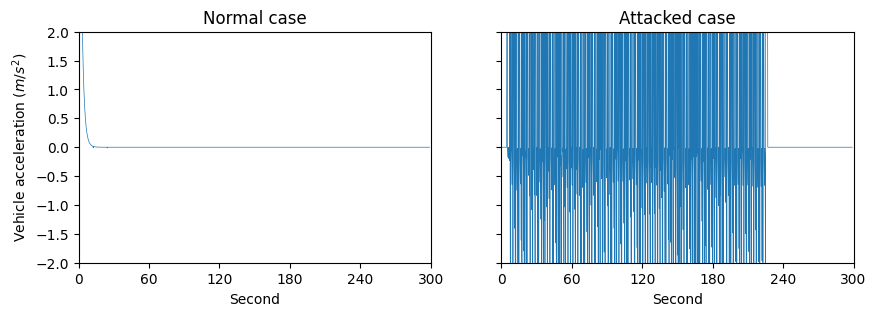

In [67]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1,2,figsize=(10, 3), sharex=True, sharey=True)

axs[0].plot(normal_acc, lw=0.5)

axs[1].plot(attacked_acc, lw=0.5)

axs[0].set_ylabel(r"Vehicle acceleration ($m/s^2$)")

axs[0].set_xticks(np.arange(0,  3001, 600))

axs[0].set_xticklabels(np.arange(0, 301, 60))

axs[0].set_xlabel("Second")
axs[1].set_xlabel("Second")

axs[0].set_title("Normal case")
axs[1].set_title("Attacked case")

axs[0].set_xlim([0, 3000])
axs[0].set_ylim([-2, 2])
axs[1].set_xlim([0, 3000])
axs[1].set_ylim([-2, 2])

(0.0, 12.0)

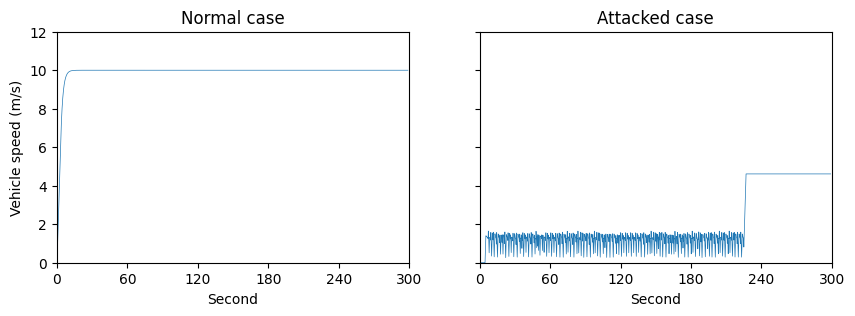

In [68]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1,2,figsize=(10, 3), sharex=True, sharey=True)

axs[0].plot(normal_speed, lw=0.5)

axs[1].plot(attacked_speed, lw=0.5)

axs[0].set_ylabel(r"Vehicle speed (m/s)")

axs[0].set_xticks(np.arange(0, 3001, 600))

axs[0].set_xticklabels(np.arange(0, 301, 60))

axs[0].set_xlabel("Second")
axs[1].set_xlabel("Second")

axs[0].set_title("Normal case")
axs[1].set_title("Attacked case")

axs[0].set_xlim([0, 3000])
axs[0].set_ylim([0, 12])
axs[1].set_xlim([0, 3000])
axs[1].set_ylim([0, 12])

Question: how long the attack will start dissipating?

Answer: 230 seconds.

A more interesting question: How long the attack will start dissipated with multiple vehicles (1 CV + 99 human-drived vehicle)?

In [69]:
vehicle_state

{'acc': 0.0,
 'bearing': -66.6444351351314,
 'x': 0.00013887954302392217,
 'y': 0.0021726572316489554,
 'ID': 0,
 'state': -1,
 'v_type': 3,
 'speed': 9.99966923955379}

Normal case

In [70]:
# clear up the Kafka data stream
kafkaDataProcessor.clear()

sim_client.reset()

# sim_client.start_viz()
# tick for 1 second
sim_client.tick(10)

sim_client.generate_trip_between_roads(list(range(1, 101)), "-20", "-20")
controller = HeadingAwareController(1)
sim_client.update_vehicle_sensor_type(1, 1, True)

normal_data = {}

# insert the attacked data 
for i in range(6000):
      sim_client.tick(1)
      data_stream = kafkaDataProcessor.process()
      if data_stream is not None:
            vids = [data['vid'] for data in data_stream]
            if 1 in vids:
                  acc = controller.compute_acceleration(data_stream)
                  sim_client.control_vehicle(1, acc, True)
            else:
                  sim_client.control_vehicle(1, -0.01, True)  # no signal then keep the same speed
      else:
            sim_client.control_vehicle(1, -0.01, True)  # no signal then keep the same speed
      
      vehicle_states = sim_client.query_vehicle(list(range(1, 101)), True)['DATA']
      for vid, vehicle_state in zip(list(range(1,101)), vehicle_states):
            if vid not in normal_data:
                  normal_data[vid] = []
            # Append the vehicle state to the list for this vid
            normal_data[vid].append(vehicle_state)

Attacked case

In [71]:
sim_client.terminate()
# clear up the Kafka data stream
kafkaDataProcessor.clear()

sim_dirs = prepare_sim_dirs(config)
run_simulation_in_docker(config)
sim_client = METSRClient(host="localhost", sim_folder=sim_dirs[0], port=4000, verbose=False)


Attempt to connect to ws://localhost:4000 failed. Waiting for 10 seconds before trying again... (5 attempts remaining)
Connection established!


In [72]:
# sim_client.start_viz()
# tick for 1 second
sim_client.tick(10)

sim_client.generate_trip_between_roads(list(range(1, 101)), "-20", "-20")
controller = HeadingAwareController(1)
sim_client.update_vehicle_sensor_type(1, 1, True)

attacked_data = {}
# insert the attacked data 
for i in range(6000):
      sim_client.tick(1)
      if i + 10 < 3000:
            if replay_data[i+10] is not None:
                  for data in replay_data[i+10]:
                        kafkaDataSender.send("bsm", data)
      data_stream = kafkaDataProcessor.process()
      if data_stream is not None:
            vids = [data['vid'] for data in data_stream]
            if 1 in vids:
                  acc = controller.compute_acceleration(data_stream)
                  sim_client.control_vehicle(1, acc, True)
            else:
                  sim_client.control_vehicle(1, -0.01, True)  # no signal then keep the same speed
      else:
            sim_client.control_vehicle(1, -0.01, True)  # no signal then keep the same speed
      vehicle_states = sim_client.query_vehicle(list(range(1, 101)), True)['DATA']
      for vid, vehicle_state in zip(list(range(1,101)), vehicle_states):
            if vid not in attacked_data:
                  attacked_data[vid] = []
            # Append the vehicle state to the list for this vid
            attacked_data[vid].append(vehicle_state)

In [73]:
sim_client.terminate()

os.chdir("docker")
os.system("docker-compose down")
os.chdir("..")

In [ ]:
# normal_data
# attacked_data

(0.0, 17.0)

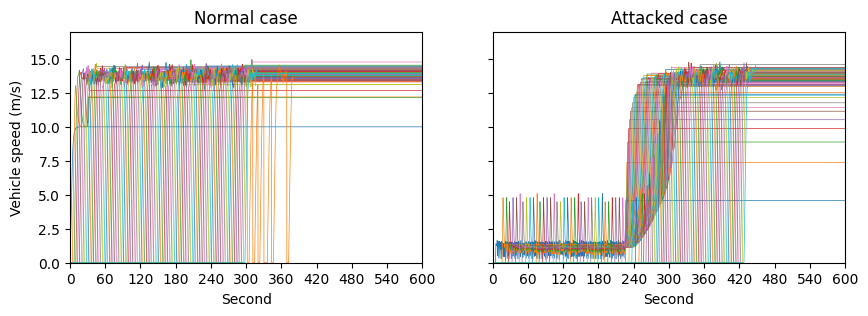

In [74]:
# data analysis
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1,2,figsize=(10, 3), sharex=True, sharey=True)

for vid in range(1, 101):
      normal_speed = [data['speed'] for data in normal_data[vid]]
      attacked_speed = [data['speed'] for data in attacked_data[vid]]

      axs[0].plot(normal_speed, lw=0.5)
      axs[1].plot(attacked_speed, lw=0.5)

axs[0].set_ylabel(r"Vehicle speed (m/s)")

axs[0].set_xticks(np.arange(0, 6001, 600))

axs[0].set_xticklabels(np.arange(0, 601, 60))

axs[0].set_xlabel("Second")
axs[1].set_xlabel("Second")

axs[0].set_title("Normal case")
axs[1].set_title("Attacked case")

axs[0].set_xlim([0, 6000])
axs[0].set_ylim([0, 17])
axs[1].set_xlim([0, 6000])
axs[1].set_ylim([0, 17])

(-3.0, 3.0)

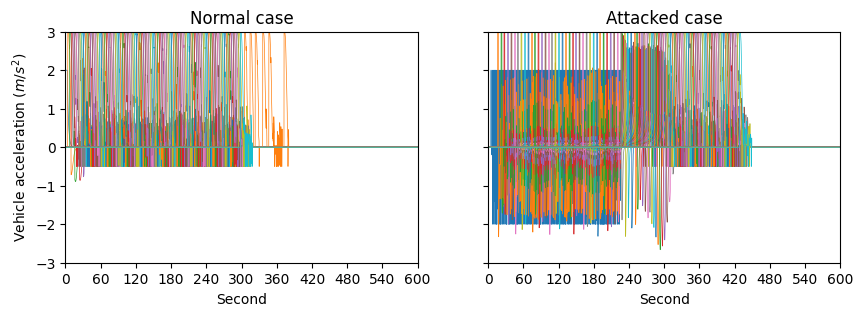

In [76]:
# data analysis
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1,2,figsize=(10, 3), sharex=True, sharey=True)

for vid in range(1, 101):
      normal_acc = [data['acc'] for data in normal_data[vid]]
      attacked_acc = [data['acc'] for data in attacked_data[vid]]

      axs[0].plot(normal_acc, lw=0.5)
      axs[1].plot(attacked_acc, lw=0.5)

axs[0].set_ylabel(r"Vehicle acceleration ($m/s^2$)")

axs[0].set_xticks(np.arange(0, 6001, 600))

axs[0].set_xticklabels(np.arange(0, 601, 60))

axs[0].set_xlabel("Second")
axs[1].set_xlabel("Second")

axs[0].set_title("Normal case")
axs[1].set_title("Attacked case")

axs[0].set_xlim([0, 6000])
axs[0].set_ylim([-3, 3])
axs[1].set_xlim([0, 6000])
axs[1].set_ylim([-3, 3])

From the above figures, the impact of the attack would take round 100 seconds (230s to 330s) to fully recover.

# Attack 2: Maneuver based attack

Adversarial breaking.

Adversarial driving.

In [77]:
from utils.util import *
from clients.METSRClient import METSRClient
import numpy as np
from utils.util import *
from clients.METSRClient import METSRClient
from clients.KafkaDataProcessor import KafkaDataProcessor
from clients.KafkaDataSender import KafkaDataSender

In [78]:
# Define a controller 
import math

class PlatooningController:
    def __init__(self, ego_vid, target_velocity=15.0, max_acceleration=2.0, kp=0.5, min_gap=5.0, cone_angle_deg=60):
        self.ego_vid = ego_vid
        self.target_velocity = target_velocity
        self.max_acceleration = max_acceleration
        self.kp = kp
        self.min_gap = min_gap
        self.cone_angle = math.radians(cone_angle_deg / 2)

    def haversine_meters(self, lat1, lon1, lat2, lon2):
        """Approximate small distance in meters (equirectangular)"""
        R = 6371000  # radius of Earth in meters
        x = math.radians(lon2 - lon1) * math.cos(math.radians((lat1 + lat2) / 2))
        y = math.radians(lat2 - lat1)
        return R * math.sqrt(x*x + y*y)

    def compute_acceleration(self, data_stream):
        ego = next((v for v in data_stream if v['vid'] == self.ego_vid), None)
        if not ego:
            raise ValueError("Ego vehicle not found")

        ego_lat = ego['latitude']
        ego_lon = ego['longitude']
        ego_vel = ego['velocity']

        # Find valid front vehicles in heading cone
        front_candidates = []
        for v in data_stream:
            if v['vid'] == self.ego_vid - 1:
                dist = self.haversine_meters(ego_lat, ego_lon, v['latitude'], v['longitude'])
                front_candidates.append((dist, v))

        if front_candidates:
            front_dist, front = min(front_candidates, key=lambda x: x[0])
            relative_speed = ego_vel - front['velocity']
        else:
            front = None
            front_dist = float('inf')
            relative_speed = 0.0

        # --- Control Logic ---
        if front and front_dist < self.min_gap:
            acceleration = -self.max_acceleration
        elif front and front_dist < 2 * self.min_gap and relative_speed > 0:
            decel = min(self.max_acceleration, relative_speed ** 2 / (2 * (front_dist - self.min_gap)))
            acceleration = -decel
        else:
            error = self.target_velocity - ego_vel
            acceleration = self.kp * error

        return max(-self.max_acceleration, min(self.max_acceleration, acceleration))


In [79]:
config = read_run_config("configs/run_cosim_CARLAT6.json")
config.verbose = False 

os.chdir("docker")
os.system("docker-compose up -d")
time.sleep(10) # wait 10s for the Kafka servers to be up
os.chdir("..")

kafkaDataProcessor = KafkaDataProcessor(config)
kafkaDataSender = KafkaDataSender(config)

In [80]:
sim_dirs = prepare_sim_dirs(config)
run_simulation_in_docker(config)

print(sim_dirs)


['output/CARLAT06_20250521_132017_seed_42']


In [81]:
# Set up a larger timeout (default is 30s) if your map/vehicle number is huge
sim_client = METSRClient(host="localhost", sim_folder=sim_dirs[0], port = config.ports[0], verbose=config.verbose) 
kafkaDataProcessor.clear()

Attempt to connect to ws://localhost:4000 failed. Waiting for 10 seconds before trying again... (5 attempts remaining)
Connection established!


In [82]:
# Create one vehicle in front of the platoon fleet
sim_client.generate_trip_between_roads(0, "-48#0", "-50")

# Create 5 vehicles as a platoon fleet
for i in range(1, 6):
    sim_client.generate_trip_between_roads(i, "4", "-50")
    sim_client.update_vehicle_sensor_type(i, 1, True)

# Set up the controller for the rest vehicle in the platoon except for the first one
controllers = {}
for i in range(2, 6):
    controllers[i] = PlatooningController(i)

In [83]:
# Normal case
normal_data = {}
for i in range(3000):
      sim_client.tick(1)
      data_stream = kafkaDataProcessor.process()
      if data_stream is not None:
            vids = [data['vid'] for data in data_stream]
            for j in range(2, 6):
                  if j in vids:
                        acc = controllers[j].compute_acceleration(data_stream)
                        sim_client.control_vehicle(j, acc, True)
                  else:
                        sim_client.control_vehicle(j, -0.01, True)  # no signal then keep the same speed
            
      else:
            for j in range(2, 6):
                  sim_client.control_vehicle(j, -0.01, True)  # no signal then keep the same speed
      vehicle_states = sim_client.query_vehicle(list(range(6)), True, True)['DATA']
      for vid, vehicle_state in zip(list(range(6)), vehicle_states):
            if vid not in normal_data:
                  normal_data[vid] = []
            # Append the vehicle state to the list for this vid
            normal_data[vid].append(vehicle_state)

In [84]:
sim_client.terminate()
kafkaDataProcessor.clear()

In [85]:
sim_dirs = prepare_sim_dirs(config)
run_simulation_in_docker(config)

sim_client = METSRClient(host="localhost", sim_folder=sim_dirs[0], port = config.ports[0], verbose=config.verbose) 
# Create one vehicle in front of the platoon fleet
sim_client.generate_trip_between_roads(0, "-48#0", "-50")

# Create 10 vehicles as a platoon fleet
for i in range(1, 6):
    sim_client.generate_trip_between_roads(i, "4", "-50")
    sim_client.update_vehicle_sensor_type(i, 1, True)

# Set up the controller for the rest vehicle in the platoon except for the first one
controllers = {}
for i in range(2, 6):
    controllers[i] = PlatooningController(i)

Attempt to connect to ws://localhost:4000 failed. Waiting for 10 seconds before trying again... (5 attempts remaining)
Connection established!


In [86]:
# Attacked case
attacked_data = {}
for i in range(3000):
      sim_client.tick(1)
      data_stream = kafkaDataProcessor.process()
      if data_stream is not None:
            vids = [data['vid'] for data in data_stream]
            for j in range(2, 6):
                  if j in vids:
                        acc = controllers[j].compute_acceleration(data_stream)
                        sim_client.control_vehicle(j, acc, True)
                  else:
                        sim_client.control_vehicle(j, -0.01, True)  # no signal then keep the same speed
      else:
            for j in range(2, 6):
                  sim_client.control_vehicle(j, -0.01, True)  # no signal then keep the same speed

      # attack by randomly apply the acceleration and deceleartion behavior   
      if (i//10) % 2 == 0:
            sim_client.control_vehicle(0, -0.5, True)
      else:
            sim_client.control_vehicle(0, 0.6, True)

      vehicle_states = sim_client.query_vehicle(list(range(6)), True, True)['DATA']
      for vid, vehicle_state in zip(list(range(6)), vehicle_states):
            if vid not in attacked_data:
                  attacked_data[vid] = []
            # Append the vehicle state to the list for this vid
            attacked_data[vid].append(vehicle_state)
      

In [87]:
sim_client.terminate()

os.chdir("docker")
os.system("docker-compose down")
os.chdir("..")

Text(0.5, 1.0, 'Attacked case')

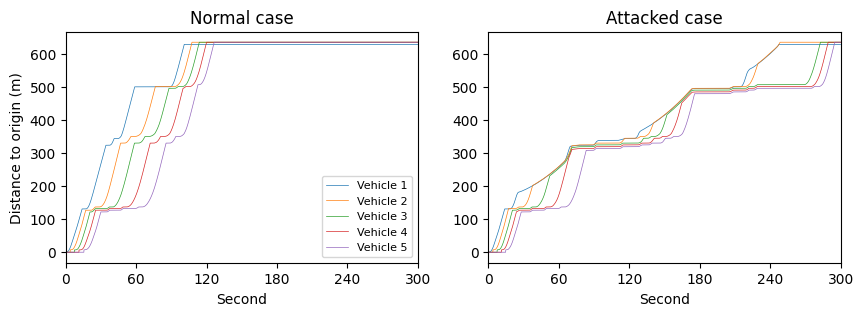

In [91]:
# data analysis
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1,2,figsize=(10, 3), sharex=True, sharey=False)

for vid in range(1, 6):
      x0, y0 = normal_data[vid][0]['x'], normal_data[vid][0]['y']

      normal_distance = [np.sqrt((data['x'] - x0)**2 + (data['y'] - y0)**2) for data in normal_data[vid]]
      attacked_distance = [np.sqrt((data['x'] - x0)**2 + (data['y'] - y0)**2) for data in attacked_data[vid]]

      axs[0].plot(normal_distance, label=f"Vehicle {vid}", lw=0.5)
      axs[1].plot(attacked_distance, label=f"Vehicle {vid}", lw=0.5)

axs[0].set_ylabel("Distance to origin (m)")

axs[0].set_xticks(np.arange(0, 3001, 600))

axs[0].set_xticklabels(np.arange(0, 301, 60))

axs[0].set_xlabel("Second")
axs[1].set_xlabel("Second")

axs[0].legend(loc='lower right', fontsize=8)

axs[0].set_xlim([0, 3000])
axs[1].set_xlim([0, 3000])

axs[0].set_title("Normal case")
axs[1].set_title("Attacked case")

In the attacked case, the platooning was greatly disturbed, breaking the fleet into two, also cause the travel time being doubled.

In [ ]:
sim_client.terminate()

os.chdir("docker")
os.system("docker-compose down")
os.chdir("..")

Bonus question: what it looks like for a network full of traffic.

In [19]:
config = read_run_config("configs/run_cosim_CARLAT6.json")
config.verbose = False 

os.chdir("docker")
os.system("docker-compose up -d")
time.sleep(10) # wait 10s for the Kafka servers to be up
os.chdir("..")

kafkaDataProcessor = KafkaDataProcessor(config)
kafkaDataSender = KafkaDataSender(config)

sim_dirs = prepare_sim_dirs(config)
run_simulation_in_docker(config)

sim_client = METSRClient(host="localhost", sim_folder=sim_dirs[0], port = config.ports[0], verbose=config.verbose) 

# Generating 100 background trips and preheat for 600 ticks (10 min).
for i in range(100):
      sim_client.generate_trip(i+6, -1, -1)
sim_client.tick(600)

sim_client.generate_trip_between_roads(0, "-48#0", "-50")
# Create 5 vehicles as a platoon fleet
for i in range(1, 6):
    sim_client.generate_trip_between_roads(i, "4", "-50")
    sim_client.update_vehicle_sensor_type(i, 1, True)

# Set up the controller for the rest vehicle in the platoon except for the first one
controllers = {}
for i in range(2, 6):
    controllers[i] = PlatooningController(i)

# Normal case
normal_data2 = {}
for i in range(6000):
      sim_client.tick(1)
      data_stream = kafkaDataProcessor.process()
      if data_stream is not None:
            vids = [data['vid'] for data in data_stream]
            for j in range(2, 6):
                  if j in vids:
                        acc = controllers[j].compute_acceleration(data_stream)
                        sim_client.control_vehicle(j, acc, True)
                  else:
                        sim_client.control_vehicle(j, -0.01, True)  # no signal then keep the same speed
      else:
            for j in range(2, 6):
                  sim_client.control_vehicle(j, -0.01, True)  # no signal then keep the same speed

      # attack by randomly apply the acceleration and deceleartion behavior   
      if (i//10) % 2 == 0:
            sim_client.control_vehicle(0, -0.5, True)
      else:
            sim_client.control_vehicle(0, 0.6, True)

      vehicle_states = sim_client.query_vehicle(list(range(106)), True, True)['DATA']
      for vid, vehicle_state in zip(list(range(106)), vehicle_states):
            if vid not in normal_data2:
                  normal_data2[vid] = []
            # Append the vehicle state to the list for this vid
            normal_data2[vid].append(vehicle_state)

sim_client.terminate()

os.chdir("docker")
os.system("docker-compose down")
os.chdir("..")

Attempt to connect to ws://localhost:4000 failed. Waiting for 10 seconds before trying again... (5 attempts remaining)
Connection established!


In [94]:
config = read_run_config("configs/run_cosim_CARLAT6.json")
config.verbose = False 

os.chdir("docker")
os.system("docker-compose up -d")
time.sleep(10) # wait 10s for the Kafka servers to be up
os.chdir("..")

kafkaDataProcessor = KafkaDataProcessor(config)
kafkaDataSender = KafkaDataSender(config)

sim_dirs = prepare_sim_dirs(config)
run_simulation_in_docker(config)

sim_client = METSRClient(host="localhost", sim_folder=sim_dirs[0], port = config.ports[0], verbose=config.verbose) 


# Generating 100 background trips and preheat for 600 ticks (10 min).
for i in range(100):
      sim_client.generate_trip(i+6, -1, -1)
sim_client.tick(600)

# Create one vehicle in front of the platoon fleet
sim_client.generate_trip_between_roads(0, "-48#0", "-50")

# Create 5 vehicles as a platoon fleet
for i in range(1, 6):
    sim_client.generate_trip_between_roads(i, "4", "-50")
    sim_client.update_vehicle_sensor_type(i, 1, True)

# Set up the controller for the rest vehicle in the platoon except for the first one
controllers = {}
for i in range(2, 6):
    controllers[i] = PlatooningController(i)

# Attacked case
attacked_data2 = {}
for i in range(6000):
      sim_client.tick(1)
      data_stream = kafkaDataProcessor.process()
      if data_stream is not None:
            vids = [data['vid'] for data in data_stream]
            for j in range(2, 6):
                  if j in vids:
                        acc = controllers[j].compute_acceleration(data_stream)
                        sim_client.control_vehicle(j, acc, True)
                  else:
                        sim_client.control_vehicle(j, -0.01, True)  # no signal then keep the same speed
      else:
            for j in range(2, 6):
                  sim_client.control_vehicle(j, -0.01, True)  # no signal then keep the same speed

      # attack by randomly apply the acceleration and deceleartion behavior   
      if (i//10) % 2 == 0:
            sim_client.control_vehicle(0, -0.5, True)
      else:
            sim_client.control_vehicle(0, 0.6, True)

      vehicle_states = sim_client.query_vehicle(list(range(106)), True, True)['DATA']
      for vid, vehicle_state in zip(list(range(106)), vehicle_states):
            if vid not in attacked_data2:
                  attacked_data2[vid] = []
            # Append the vehicle state to the list for this vid
            attacked_data2[vid].append(vehicle_state)



Attempt to connect to ws://localhost:4000 failed. Waiting for 10 seconds before trying again... (5 attempts remaining)
Connection established!


In [ ]:
sim_client.start_viz()

Serving output/CARLAT06_20250521_133416_seed_42\trajectory_output\2025-05-21-1234-25 with CORS enabled on port 8000...


127.0.0.1 - - [21/May/2025 13:35:58] "OPTIONS / HTTP/1.1" 200 -
127.0.0.1 - - [21/May/2025 13:35:58] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [21/May/2025 13:36:01] "OPTIONS /EOut.1.json HTTP/1.1" 200 -
127.0.0.1 - - [21/May/2025 13:36:01] "GET /EOut.1.json HTTP/1.1" 200 -
127.0.0.1 - - [21/May/2025 13:36:01] "OPTIONS /EOut.2.json HTTP/1.1" 200 -
127.0.0.1 - - [21/May/2025 13:36:01] "GET /EOut.2.json HTTP/1.1" 200 -
127.0.0.1 - - [21/May/2025 13:36:02] "OPTIONS /EOut.3.json HTTP/1.1" 200 -
127.0.0.1 - - [21/May/2025 13:36:02] "GET /EOut.3.json HTTP/1.1" 200 -
127.0.0.1 - - [21/May/2025 13:36:02] "OPTIONS /EOut.4.json HTTP/1.1" 200 -
127.0.0.1 - - [21/May/2025 13:36:03] "GET /EOut.4.json HTTP/1.1" 200 -
127.0.0.1 - - [21/May/2025 13:36:03] "OPTIONS /EOut.5.json HTTP/1.1" 200 -
127.0.0.1 - - [21/May/2025 13:36:03] "GET /EOut.5.json HTTP/1.1" 200 -
127.0.0.1 - - [21/May/2025 13:36:04] "OPTIONS /EOut.6.json HTTP/1.1" 200 -
127.0.0.1 - - [21/May/2025 13:36:04] "GET /EOut.6.json HTTP/1.1" 200 -


In [ ]:
sim_client.terminate()

os.chdir("docker")
os.system("docker-compose down")
os.chdir("..")

In [16]:
normal_data2[0]

[{'acc': 0.0,
  'bearing': -89.99999999914013,
  'x': 25.079999999999988,
  'y': 23.03000000000003,
  'ID': 0,
  'state': -1,
  'v_type': 3,
  'speed': 14.106306924436467},
 {'acc': 0.0,
  'bearing': -89.99999999914013,
  'x': 25.079999999999988,
  'y': 23.03000000000003,
  'ID': 0,
  'state': -1,
  'v_type': 3,
  'speed': 14.106306924436467},
 {'acc': 0.0,
  'bearing': -89.99999999914013,
  'x': 25.079999999999988,
  'y': 23.03000000000003,
  'ID': 0,
  'state': -1,
  'v_type': 3,
  'speed': 14.106306924436467},
 {'acc': 0.0,
  'bearing': -89.99999999914013,
  'x': 25.079999999999988,
  'y': 23.03000000000003,
  'ID': 0,
  'state': -1,
  'v_type': 3,
  'speed': 14.106306924436467},
 {'acc': 0.0,
  'bearing': -89.99999999914013,
  'x': 25.079999999999988,
  'y': 23.03000000000003,
  'ID': 0,
  'state': -1,
  'v_type': 3,
  'speed': 14.106306924436467},
 {'acc': 0.0,
  'bearing': -89.99999999914013,
  'x': 25.079999999999988,
  'y': 23.03000000000003,
  'ID': 0,
  'state': -1,
  'v_type

In [27]:
normal_on_road = [[data['state']>0  for data in normal_data2[i] ] for i in range(106)]
attacked_on_road = [[data['state']>0  for data in attacked_data2[i]] for i in range(106)]

Text(0.5, 0, 'Second')

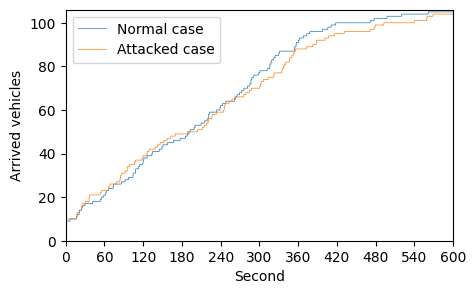

In [93]:
# data analysis
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1,1,figsize=(5, 3), sharex=True, sharey=False)

axs.plot(106 - np.sum(normal_on_road, axis = 0), label = "Normal case", lw = 0.5)
axs.plot(106 - np.sum(attacked_on_road, axis = 0), label = "Attacked case", lw = 0.5)

axs.set_ylabel("Arrived vehicles")

axs.set_xticks(np.arange(0, 6001, 600))

axs.set_xticklabels(np.arange(0, 601, 60))

plt.legend()

plt.xlim([0, 6000])
plt.ylim([0, 106])

axs.set_xlabel("Second")

# Attack 3: Adversarial booking attack

In [1]:
from utils.util import *
from clients.METSRClient import METSRClient

In [2]:
config = read_run_config("configs/run_interactive_NYC.json")
config.verbose = True # set to True to see the message

In [3]:
sim_dirs = prepare_sim_dirs(config)
run_simulation_in_docker(config)

print(sim_dirs)

No port number specified, find available ports for simulation instances
Container ID: ae8b3d5d7bbbf7ebc75f538bb2ea23d3c844acd5f90cec2a39e0c416a860c7dd

Error msg: 
['output/NYC_20250530_152333_seed_42']


In [4]:
client = METSRClient(host="localhost", sim_folder=sim_dirs[0], port=config.ports[0], verbose=False, timeout=300)

Attempt to connect to ws://localhost:59396 failed. Waiting for 10 seconds before trying again... (5 attempts remaining)
Connection established!


In [5]:
client.tick(6000, wait_forever=True) # preheat for 6000 ticks (20 min)

# Generating 30 trips every 50 ticks (10 s), lasting for 3000 ticks (600 seconds)
for i in range(60):
      client.add_taxi_requests([180]*10, [218]*10, 1)
      client.add_taxi_requests([131]*10, [218]*10, 1)
      client.add_taxi_requests([140]*10, [218]*10, 1)
      client.tick(50)

client.tick(3000, wait_forever=True) 

In [ ]:
#  Check the replay in https://engineering.purdue.edu/HSEES/METSRVis/
client.start_viz()

Serving output/NYC_20250530_152333_seed_42\trajectory_output\2025-05-30-0223-55 with CORS enabled on port 8000...


127.0.0.1 - - [30/May/2025 15:47:57] "OPTIONS / HTTP/1.1" 200 -
127.0.0.1 - - [30/May/2025 15:47:57] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [30/May/2025 15:48:00] "OPTIONS /EOut.1.json HTTP/1.1" 200 -
127.0.0.1 - - [30/May/2025 15:48:00] "GET /EOut.1.json HTTP/1.1" 200 -
127.0.0.1 - - [30/May/2025 15:48:00] "OPTIONS /EOut.2.json HTTP/1.1" 200 -
127.0.0.1 - - [30/May/2025 15:48:01] "GET /EOut.2.json HTTP/1.1" 200 -
127.0.0.1 - - [30/May/2025 15:48:03] "OPTIONS /EOut.3.json HTTP/1.1" 200 -
127.0.0.1 - - [30/May/2025 15:48:03] "GET /EOut.3.json HTTP/1.1" 200 -
127.0.0.1 - - [30/May/2025 15:48:04] "OPTIONS /EOut.4.json HTTP/1.1" 200 -
127.0.0.1 - - [30/May/2025 15:48:04] "GET /EOut.4.json HTTP/1.1" 200 -
127.0.0.1 - - [30/May/2025 15:48:05] "OPTIONS /EOut.5.json HTTP/1.1" 200 -
127.0.0.1 - - [30/May/2025 15:48:05] "GET /EOut.5.json HTTP/1.1" 200 -
127.0.0.1 - - [30/May/2025 15:48:06] "OPTIONS /EOut.6.json HTTP/1.1" 200 -
127.0.0.1 - - [30/May/2025 15:48:06] "GET /EOut.6.json HTTP/1.1" 200 -


In [7]:
client.terminate()

Visualization server stopped.


In [8]:
sim_dirs = prepare_sim_dirs(config)
run_simulation_in_docker(config)
client = METSRClient(host="localhost", sim_folder=sim_dirs[0], port=config.ports[0], verbose=False, timeout=300)

print(sim_dirs)

No port number specified, find available ports for simulation instances
Container ID: f0b9e8c8d864fee05b93f46e70dd96d8202b52ec8f946edbae36e6e1825db90b

Error msg: 
Attempt to connect to ws://localhost:64172 failed. Waiting for 10 seconds before trying again... (5 attempts remaining)
Connection established!
['output/NYC_20250530_155532_seed_42']


In [9]:
client.tick(12000, wait_forever=True) # no attack case

In [10]:
#  Check the replay in https://engineering.purdue.edu/HSEES/METSRVis/
client.start_viz()

Serving output/NYC_20250530_155532_seed_42\trajectory_output\2025-05-30-0255-56 with CORS enabled on port 8000...


127.0.0.1 - - [30/May/2025 15:59:40] "OPTIONS / HTTP/1.1" 200 -
127.0.0.1 - - [30/May/2025 15:59:40] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [30/May/2025 15:59:42] "OPTIONS /EOut.1.json HTTP/1.1" 200 -
127.0.0.1 - - [30/May/2025 15:59:42] "GET /EOut.1.json HTTP/1.1" 200 -
127.0.0.1 - - [30/May/2025 15:59:43] "OPTIONS /EOut.2.json HTTP/1.1" 200 -
127.0.0.1 - - [30/May/2025 15:59:43] "GET /EOut.2.json HTTP/1.1" 200 -
127.0.0.1 - - [30/May/2025 15:59:43] "OPTIONS /EOut.3.json HTTP/1.1" 200 -
127.0.0.1 - - [30/May/2025 15:59:43] "GET /EOut.3.json HTTP/1.1" 200 -
127.0.0.1 - - [30/May/2025 15:59:44] "OPTIONS /EOut.4.json HTTP/1.1" 200 -
127.0.0.1 - - [30/May/2025 15:59:44] "GET /EOut.4.json HTTP/1.1" 200 -
127.0.0.1 - - [30/May/2025 15:59:45] "OPTIONS /EOut.5.json HTTP/1.1" 200 -
127.0.0.1 - - [30/May/2025 15:59:45] "GET /EOut.5.json HTTP/1.1" 200 -
127.0.0.1 - - [30/May/2025 15:59:45] "OPTIONS /EOut.6.json HTTP/1.1" 200 -
127.0.0.1 - - [30/May/2025 15:59:46] "GET /EOut.6.json HTTP/1.1" 200 -


In [12]:
client.terminate()

Visualization server stopped.


# Attack 4: Route guidance attacks

In [11]:
from utils.util import *
from clients.METSRClient import METSRClient

In [63]:
import random

def weight_manipulation_attack(sim_client, road_id: str, factor: float):
    """
    Manipulate the perceived travel time weight of a given road.

    Parameters
    ----------
    sim_client
        The simulation client instance.
    road_id
        Identifier of the road whose weight will be altered.
    factor
        Multiplicative factor to apply to the original travel time.
    """
    # Query the current weight
    current_weight = sim_client.query_road_weights(road_id)['DATA'][0]['weight']
    # Compute new weight
    manipulated_weight = current_weight * factor
    # Apply the new weight
    sim_client.update_road_weights(road_id, manipulated_weight)


def random_detour_attack(sim_client, vehicle_id: int, start_road: str, end_road: str):
    """
    Force a vehicle to take a detour via a randomly selected intermediate node.

    Parameters
    ----------
    sim_client
        The simulation client instance.
    vehicle_id
        Identifier of the vehicle to reroute.
    start_road
        Origin road identifier.
    end_road
        Destination road identifier.
    """
    # Fetch all possible nodes and exclude origin/destination
    all_nodes = sim_client.query_road()['orig_id']
    candidates = [n for n in all_nodes if n not in {start_road, end_road}]

    # Pick one node at random for the detour
    intermediate_node = random.choice(candidates)

    # Query the two subroutes
    part1 = sim_client.query_route_between_roads(start_road, intermediate_node)['DATA'][0]['road_list']
    part2 = sim_client.query_route_between_roads(intermediate_node, end_road)['DATA'][0]['road_list']

    # Merge into a single alternative path
    detour_route = part1[:-1] + part2

    # Advance simulation and apply the detour
    sim_client.update_vehicle_route(vehicle_id, detour_route, True)


# Attack 1: Reduce perceived weight on road '-0' by half
# weight_manipulation_attack(sim_client, road_id='-0', factor=1.5)

# Attack 2: Reroute vehicle 0 between '-62' and '-3' via a random node
# random_detour_attack(sim_client, vehicle_id=0, start_road='-62', end_road='-3')


In [13]:
config = read_run_config("configs/run_interactive_NYC_blank.json")
config.verbose = False 

In [15]:
sim_dirs = prepare_sim_dirs(config)
run_simulation_in_docker(config)

print(sim_dirs)
sim_client = METSRClient(host="localhost", sim_folder=sim_dirs[0], port=config.ports[0], verbose=False, timeout=300)

No port number specified, find available ports for simulation instances
['output/NYC_20250530_162337_seed_42']
Attempt to connect to ws://localhost:56293 failed. Waiting for 10 seconds before trying again... (5 attempts remaining)
Connection established!


In [16]:
start_points = ["46931643"]
end_points = ["483360105#0"]

In [ ]:
# Attack 1, random detour attack
xs, ys = [], []

# Generate the initial trip for the vehicle
sim_client.generate_trip_between_roads(0, start_points[0], end_points[0])

sim_client.tick()

random_detour_attack(sim_client, vehicle_id=0, start_road=start_points[0], end_road=end_points[0])

for i in range(7200):
      query_res = sim_client.query_vehicle(0, True)
      xs.append(query_res['DATA'][0]['x'])
      ys.append(query_res['DATA'][0]['y'])
      sim_client.tick(5)

In [37]:
for i in range(3600):
      query_res = sim_client.query_vehicle(0, True)
      xs.append(query_res['DATA'][0]['x'])
      ys.append(query_res['DATA'][0]['y'])
      sim_client.tick(5)

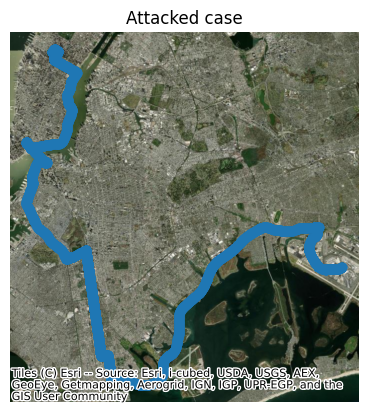

In [38]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd

# Example 1: Collect and visualize the trajectory of one vehicle
fig, ax = plt.subplots()

# add the NYC map
gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(xs, ys), crs='EPSG:4326').to_crs(epsg=3857)
gdf.plot(ax = ax)
ax.set_title("Attacked case")
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

ax.set_axis_off()

plt.show()

In [25]:
sim_client.terminate()

In [26]:
sim_dirs = prepare_sim_dirs(config)
run_simulation_in_docker(config)
sim_client = METSRClient(host="localhost", sim_folder=sim_dirs[0], port=config.ports[0], verbose=False, timeout=300)

print(sim_dirs)

No port number specified, find available ports for simulation instances
Attempt to connect to ws://localhost:57149 failed. Waiting for 10 seconds before trying again... (5 attempts remaining)
Connection established!
['output/NYC_20250530_163009_seed_42']


In [23]:
xs2, ys2 = [], []

# Generate the initial trip for the vehicle
sim_client.generate_trip_between_roads(0, start_points[0], end_points[0])

sim_client.tick()

for i in range(3600):
      query_res = sim_client.query_vehicle(0, True)
      xs2.append(query_res['DATA'][0]['x'])
      ys2.append(query_res['DATA'][0]['y'])
      sim_client.tick(5)

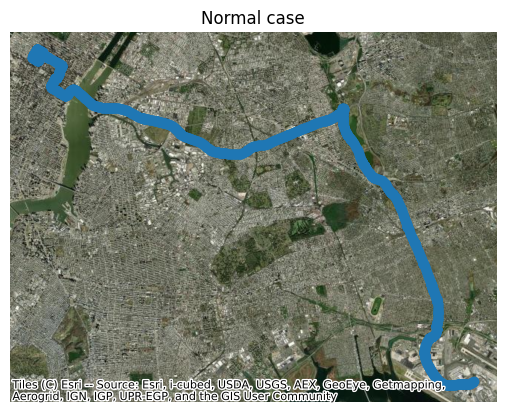

In [24]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd

# Example 1: Collect and visualize the trajectory of one vehicle
fig, ax = plt.subplots()

# add the NYC map
gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(xs2, ys2), crs='EPSG:4326').to_crs(epsg=3857)
gdf.plot(ax = ax)
ax.set_title("Normal case")
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

ax.set_axis_off()

plt.show()

In [135]:
sim_client.terminate()

In [136]:
target_links = ["40337615",\
                  "46359922",\
                  "521358284",\
                  "546364858",\
                  "11878036",\
                  "1287670362",\
                  "813727586",\
                  "1287670367",\
                  "198924625#0",\
                  "198924632",\
                  "32947293",\
                  "198924626",\
                  "198924628"]

In [137]:
sim_dirs = prepare_sim_dirs(config)
run_simulation_in_docker(config)
sim_client = METSRClient(host="localhost", sim_folder=sim_dirs[0], port=config.ports[0], verbose=False, timeout=300)

print(sim_dirs)

No port number specified, find available ports for simulation instances
Attempt to connect to ws://localhost:62145 failed. Waiting for 10 seconds before trying again... (5 attempts remaining)
Connection established!
['output/NYC_20250530_190919_seed_42']


In [138]:
# Attack 2, random detour attack
attacked_data3 = {}

# Generate the initial trip for the vehicle
sim_client.tick(1)
for target_link in target_links:
            weight_manipulation_attack(sim_client, target_link, 1000)

sim_client.generate_trip(list(range(200)), 131, 218)


for i in range(36000):  
      if i % 1500 == 0:
            for target_link in target_links:
                  weight_manipulation_attack(sim_client, target_link, 1000)
      sim_client.tick(1)
      
      vehicle_states = sim_client.query_vehicle(list(range(200)), True, True)['DATA']
      for vid, vehicle_state in zip(list(range(200)), vehicle_states):
            if vid not in attacked_data3:
                  attacked_data3[vid] = []
            # Append the vehicle state to the list for this vid
            attacked_data3[vid].append(vehicle_state)

In [126]:
sim_client.terminate()

sim_dirs = prepare_sim_dirs(config)
run_simulation_in_docker(config)
sim_client = METSRClient(host="localhost", sim_folder=sim_dirs[0], port=config.ports[0], verbose=False, timeout=300)

print(sim_dirs)

No port number specified, find available ports for simulation instances
Attempt to connect to ws://localhost:58810 failed. Waiting for 10 seconds before trying again... (5 attempts remaining)
Connection established!
['output/NYC_20250530_183954_seed_42']


In [128]:
# Generate the initial trip for the vehicle
sim_client.tick(1)
sim_client.generate_trip(list(range(200)), 131, 218)

normal_data3 = {}
for i in range(36000):
      sim_client.tick(1)
      
      vehicle_states = sim_client.query_vehicle(list(range(200)), True, True)['DATA']
      for vid, vehicle_state in zip(list(range(200)), vehicle_states):
            if vid not in normal_data3:
                  normal_data3[vid] = []
            # Append the vehicle state to the list for this vid
            normal_data3[vid].append(vehicle_state)

In [145]:
normal_on_road = [[data['state']==8  for data in normal_data3[i] ] for i in range(200)]
attacked_on_road = [[data['state']==8  for data in attacked_data3[i]] for i in range(200)]

Text(0.5, 0, 'Minute')

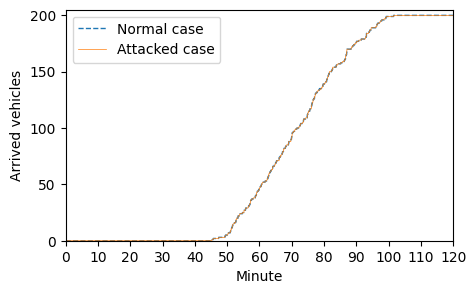

In [146]:
# data analysis
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1,1,figsize=(5, 3), sharex=True, sharey=False)

axs.plot(200 - np.sum(normal_on_road, axis = 0), '--', label = "Normal case", lw = 1.0)
axs.plot(200 - np.sum(attacked_on_road, axis = 0), label = "Attacked case", lw = 0.5)

axs.set_ylabel("Arrived vehicles")

axs.set_xticks(np.arange(0, 36001, 3000))

axs.set_xticklabels(np.arange(0, 121, 10))

plt.legend()

plt.xlim([0, 36000])
plt.ylim([0, 205])

axs.set_xlabel("Minute")

# Attack 5: Charging price spoofing

In [1]:
from utils.util import *
from clients.METSRClient import METSRClient

In [2]:
def charging_price_attack(sim_client, charger_id: int, charger_type: int, factor: float):
    """
    Manipulate the broadcasted charging price of a given charger.

    Parameters
    ----------
    sim_client
        The simulation client instance.
    charger_id
        Identifier of the charger whose price will be altered.
    charger_type
        Type of the charger (1: Level 1, 2: Level 2, 3: DC Fast).
    new_price
        New price to set for the charger.
    """
    # Query the current weight
    current_price = 0
    if charger_type == 0: # L2 charger
       current_price = sim_client.query_chargingStation(charger_id)['DATA'][0]['l2_price']
    elif charger_type == 1: # DC Fast charger
       current_price = sim_client.query_chargingStation(charger_id)['DATA'][0]['dcfc_price']
    else:
       print("Unsupported charger type: ", charger_type)
       return
    
    if current_price != 0:
      # Compute new weight
      manipulated_weight = current_price * factor
      # Apply the new weight
      sim_client.update_charging_prices(charger_id, charger_type, manipulated_weight)
    else:
      print("Current price is zero, this manipulation is skipped.")


In [3]:
config = read_run_config("configs/run_interactive_NYC.json")
config.verbose = False 

In [4]:
sim_dirs = prepare_sim_dirs(config)
run_simulation_in_docker(config)

print(sim_dirs)
sim_client = METSRClient(host="localhost", sim_folder=sim_dirs[0], port=config.ports[0], verbose=False, timeout=300)

No port number specified, find available ports for simulation instances
['output/NYC_20251006_031824_seed_42']
Attempt to connect to ws://localhost:61788 failed. Waiting for 10 seconds before trying again... (5 attempts remaining)
Connection established!


In [5]:
sim_client.tick(1000, wait_forever=True) # preheat for 1000 ticks (200 seconds)

In [6]:
sim_client.query_chargingStation()

{'id_list': [-1,
  -2,
  -3,
  -4,
  -5,
  -6,
  -7,
  -8,
  -9,
  -10,
  -11,
  -12,
  -13,
  -14,
  -15,
  -16,
  -17,
  -18,
  -19,
  -20,
  -21,
  -22,
  -23,
  -24,
  -25,
  -26,
  -27,
  -28,
  -29,
  -30,
  -31,
  -32,
  -33,
  -34,
  -35,
  -36,
  -37,
  -38,
  -39,
  -40,
  -41,
  -42,
  -43,
  -44,
  -45,
  -46,
  -47,
  -48,
  -49,
  -50,
  -51,
  -52,
  -53,
  -54,
  -55,
  -56,
  -57,
  -58,
  -59,
  -60,
  -61,
  -62,
  -63,
  -64,
  -65,
  -66,
  -67,
  -68,
  -69,
  -70,
  -71,
  -72,
  -73,
  -74,
  -75,
  -76,
  -77,
  -78,
  -79,
  -80,
  -81,
  -82,
  -83,
  -84,
  -85,
  -86,
  -87,
  -88,
  -89,
  -90,
  -91,
  -92,
  -93,
  -94,
  -95,
  -96,
  -97,
  -98,
  -99,
  -100,
  -101,
  -102,
  -103,
  -104,
  -105,
  -106,
  -107,
  -108,
  -109,
  -110,
  -111,
  -112,
  -113,
  -114,
  -115,
  -116,
  -117,
  -118,
  -119,
  -120,
  -121,
  -122,
  -123,
  -124,
  -125,
  -126,
  -127,
  -128,
  -129,
  -130,
  -131,
  -132,
  -133,
  -134,
  -135,
  -136,
  -137,
 

In [7]:
sim_client.query_chargingStation(-12)

{'DATA': [{'num_available_charger': 24,
   'l2_price': 2.0,
   'l2_charger': 24,
   'dcfc_price': 30.0,
   'dcfc_charger': 0,
   'bus_charger': 0,
   'x': -74.0160806036194,
   'y': 40.712046412972434,
   'ID': -12}],
 'TYPE': 'ANS_chargingStation'}

In [8]:
# Attack: Increase the price of L2 charger by 5 times
charging_price_attack(sim_client, charger_id=-12, charger_type=0, factor=5)

In [9]:
sim_client.query_chargingStation(-12)

{'DATA': [{'num_available_charger': 24,
   'l2_price': 10.0,
   'l2_charger': 24,
   'dcfc_price': 30.0,
   'dcfc_charger': 0,
   'bus_charger': 0,
   'x': -74.0160806036194,
   'y': 40.712046412972434,
   'ID': -12}],
 'TYPE': 'ANS_chargingStation'}

In [10]:
sim_client.terminate()